# Preprocessing/Exploratory Data Analysis/Model
First we'll read the data, then do a train-test split

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('../downloads/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:
# Replace the NaN values with empty strings
train.keyword.fillna('',inplace=True)
train.location.fillna('',inplace=True)

## Duplicated tweets
There are some duplicated tweets in the set. Some of them have been labeled as both disaster and non-disaster. In this case, we'll select the first occurence and delete the second.

In [3]:
train.drop(train.index[train.duplicated(subset='text')],inplace=True)

## Clean tweet text
Tweets contain text features that we don't want to include in the model. First, we should eliminate any web addresses, numeric features (such as dates, times, monetary values, etc.). 

In [4]:
import re

substitutions = [
    r'https?:\/\/t.co[\$-~]*(\s|$)',
    r'[0-\?][!-~]*(\s|$)',
    r'\x89Û[!-~]*(\s|$)',
    r'\x89Û',
    r'\x89ÛÒ',
    r'\x89ÛÓ',
    r'\x89ÛÏ',
    r'\x89Û\x9d',
    r'\x89Ûª',
]

def clean(tweet):
    for s in substitutions:
        tweet = re.sub(s, '', tweet)
    
    punctuations = '!?+&*[]-%.:/();$=><|{}^`'
    for p in punctuations:
        tweet = tweet.replace(p, '')
        
    return tweet.encode("ascii", "ignore").decode().lower()

train['clean_text'] = train['text'].apply(lambda x: clean(x))

All words:


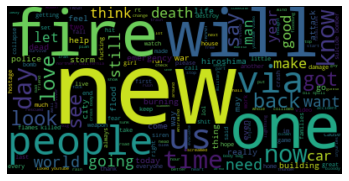

Disaster tweets:


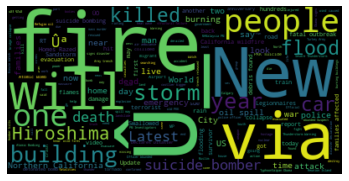

Non-disaster tweets:


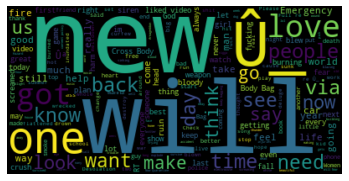

In [5]:
import matplotlib.pyplot as plt

train_tweet_text = train['clean_text']

from wordcloud import WordCloud
word_string = ''

for tweet in train_tweet_text:
    word_string += tweet
    
print('All words:')
wc = WordCloud().generate(word_string)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

print('Disaster tweets:')
word_string = ''
for tweet in train.loc[train['target'] == 1, 'text'].apply(lambda x: re.sub('(#|[!-9]|http|@)[!-~]*(\s|$)', '',x)):
    word_string += tweet
    
wc = WordCloud().generate(word_string)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

print('Non-disaster tweets:')
word_string = ''
for tweet in train.loc[train['target'] == 0, 'text'].apply(lambda x: re.sub('(#|[!-9]|http|@)[!-~]*(\s|$)', '',x)):
    word_string += tweet
    
wc = WordCloud().generate(word_string)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train,test_size = 0.33,random_state=1)
train.reset_index(inplace=True)
train.drop('index',axis=1,inplace=True)
test.reset_index(inplace=True)
test.drop('index',axis=1,inplace=True)

In [7]:
import re
from nltk import TweetTokenizer
tt = TweetTokenizer(strip_handles=True, reduce_len=True)

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(tokenizer=tt.tokenize)
train_tweet_text = train['clean_text'].apply(lambda x: re.sub('(#|[!-9]|http|@)[!-~]*(\s|$)', '',x))
test_tweet_text = test['clean_text'].apply(lambda x: re.sub('(#|[!-9]|http|@)[!-~]*(\s|$)', '',x))
cv.fit(train_tweet_text)

# Vectorize keywords and tweets
# First the training set
train_keywords = pd.DataFrame(pd.get_dummies(train.keyword,prefix='KW'))
train_tweets = pd.DataFrame(cv.transform(train_tweet_text).toarray(),columns=cv.get_feature_names())
X_train = pd.concat([train_keywords, train_tweets],axis=1)
y_train = train.target

test_keywords = pd.DataFrame(pd.get_dummies(test.keyword,prefix='KW'))
test_tweets = pd.DataFrame(cv.transform(test_tweet_text).toarray(),columns=cv.get_feature_names())
X_test = pd.concat([test_keywords, test_tweets],axis=1)
y_test = test.target
print('Number of features:',len(X_train.columns))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Number of features: 12116


In [8]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score

alphas = [0.1,1,2,4,8,16,32,64]
model = []
zero_features = []
test_f1_scores = []
train_f1_scores = []
eps = 0.001

for alpha in alphas:
    model.append(RidgeClassifier(alpha = alpha))
    model[-1].fit(X_train,y_train)
    y_pred = model[-1].predict(X_test)
    test_score = f1_score(y_test,y_pred)
    train_score = f1_score(y_train,model[-1].predict(X_train))
    test_f1_scores.append(test_score)
    train_f1_scores.append(train_score)
    zeros = 0
    for c in model[-1].coef_[0,:]:
        if (c < eps) and (c > -eps):
            zeros += 1
    zero_features.append(zeros)
    print('Alpha: ', alpha, 'Train F1:',train_score,
          'Test F1:', test_score, 'Zeros:', zeros)

Alpha:  0.1 Train F1: 0.9871645274212368 Test F1: 0.6641111643507427 Zeros: 35
Alpha:  1 Train F1: 0.9824643441664719 Test F1: 0.6940822467402207 Zeros: 64
Alpha:  2 Train F1: 0.9774964838255977 Test F1: 0.7120365667851701 Zeros: 54
Alpha:  4 Train F1: 0.9666587845826436 Test F1: 0.713697219361483 Zeros: 78
Alpha:  8 Train F1: 0.937049495434887 Test F1: 0.7183246073298429 Zeros: 122
Alpha:  16 Train F1: 0.8989923814204963 Test F1: 0.728813559322034 Zeros: 135
Alpha:  32 Train F1: 0.8545454545454546 Test F1: 0.7265917602996255 Zeros: 174
Alpha:  64 Train F1: 0.8059006211180123 Test F1: 0.7235198261814231 Zeros: 214


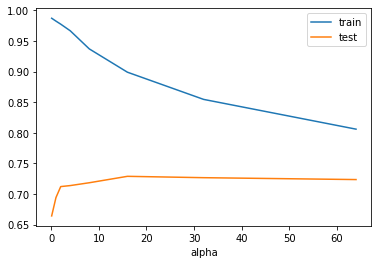

In [9]:
import matplotlib.pyplot as plt
plt.plot(alphas,train_f1_scores,label='train')
plt.plot(alphas,test_f1_scores,label='test')
plt.xlabel('alpha')
plt.legend()
plt.show()

## Adding hashtags and handles

In [6]:
regex_string = '([$-9]|http)[!-~]*(\s|$)?'
train_tweet_text = train['text'].apply(lambda x: re.sub(regex_string, ' ',x).lower())
test_tweet_text = test['text'].apply(lambda x: re.sub(regex_string, ' ',x).lower())

cv = CountVectorizer()
cv.fit(train_tweet_text)

# Vectorize keywords and tweets
# First the training set
train_keywords = pd.DataFrame(pd.get_dummies(train.keyword,prefix='KW'))
train_tweets = pd.DataFrame(cv.transform(train_tweet_text).toarray(),columns=cv.get_feature_names())
X_train = pd.concat([train_tweets],axis=1)
y_train = train.target

test_keywords = pd.DataFrame(pd.get_dummies(test.keyword,prefix='KW'))
test_tweets = pd.DataFrame(cv.transform(test_tweet_text).toarray(),columns=cv.get_feature_names())
X_test = pd.concat([test_tweets],axis=1)
y_test = test.target

In [7]:
alphas1 = [0.1,1,2,4,8,16,32,64]
model1 = []
zero_features1 = []
test_f1_scores1 = []
train_f1_scores1 = []
eps = 0.001

for alpha in alphas1:
    model1.append(RidgeClassifier(alpha = alpha))
    model1[-1].fit(X_train,y_train)
    y_pred = model1[-1].predict(X_test)
    test_score = f1_score(y_test,y_pred)
    train_score = f1_score(y_train,model1[-1].predict(X_train))
    test_f1_scores1.append(test_score)
    train_f1_scores1.append(train_score)
    zeros = 0
    for c in model1[-1].coef_[0,:]:
        if (c < eps) and (c > -eps):
            zeros += 1
    zero_features1.append(zeros)
    print('Alpha: ', alpha, 'Train F1:',train_score,
          'Test F1:', test_score, 'Zeros:', zeros)

Alpha:  0.1 Train F1: 0.9869133574007221 Test F1: 0.6679940268790443 Zeros: 54
Alpha:  1 Train F1: 0.984406779661017 Test F1: 0.7053435114503818 Zeros: 58
Alpha:  2 Train F1: 0.9796010879419763 Test F1: 0.7185750636132316 Zeros: 51
Alpha:  4 Train F1: 0.9680219278209227 Test F1: 0.7311271975180972 Zeros: 82
Alpha:  8 Train F1: 0.9460715946071594 Test F1: 0.7404699738903395 Zeros: 116
Alpha:  16 Train F1: 0.9105113636363638 Test F1: 0.7439664218258133 Zeros: 135
Alpha:  32 Train F1: 0.8665536449503513 Test F1: 0.7404661016949152 Zeros: 176
Alpha:  64 Train F1: 0.8197211155378485 Test F1: 0.724824986537426 Zeros: 216


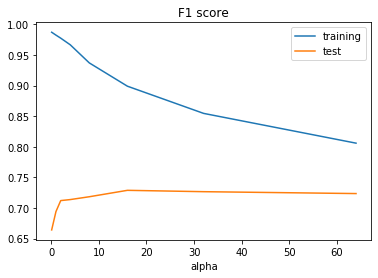

In [10]:
plt.plot(alphas,train_f1_scores,label='training')
plt.plot(alphas,test_f1_scores,label='test')
plt.xlabel('alpha')
plt.title('F1 score')
plt.legend()
plt.show()

## Adding keywords

In [11]:
regex_string = '([$-9]|http)[!-~]*(\s|$)?'
train_tweet_text = train['text'].apply(lambda x: re.sub(regex_string, ' ',x).lower())
test_tweet_text = test['text'].apply(lambda x: re.sub(regex_string, ' ',x).lower())

cv = CountVectorizer()
cv.fit(train_tweet_text)

# Vectorize keywords and tweets
# First the training set
train_keywords = pd.DataFrame(pd.get_dummies(train.keyword,prefix='KW'))
train_tweets = pd.DataFrame(cv.transform(train_tweet_text).toarray(),columns=cv.get_feature_names())
X_train = pd.concat([train_keywords,train_tweets],axis=1)
y_train = train.target

test_keywords = pd.DataFrame(pd.get_dummies(test.keyword,prefix='KW'))
test_tweets = pd.DataFrame(cv.transform(test_tweet_text).toarray(),columns=cv.get_feature_names())
X_test = pd.concat([test_keywords,test_tweets],axis=1)
y_test = test.target

Alpha:  0.1 Train F1: 0.989046842227919 Test F1: 0.680521991300145 Zeros: 54
Alpha:  1 Train F1: 0.9869281045751634 Test F1: 0.704225352112676 Zeros: 61
Alpha:  2 Train F1: 0.9817244611059043 Test F1: 0.7184170471841705 Zeros: 97
Alpha:  4 Train F1: 0.9692816635160679 Test F1: 0.7284836065573771 Zeros: 97
Alpha:  8 Train F1: 0.944738106679481 Test F1: 0.7312500000000001 Zeros: 93
Alpha:  16 Train F1: 0.9097578870139399 Test F1: 0.7418335089567966 Zeros: 142
Alpha:  32 Train F1: 0.865761689291101 Test F1: 0.736392742796158 Zeros: 178
Alpha:  64 Train F1: 0.8232570105479805 Test F1: 0.7391774891774892 Zeros: 248
Alpha:  128 Train F1: 0.7728597932679566 Test F1: 0.7231450719822813 Zeros: 378
Alpha:  256 Train F1: 0.7152281473336998 Test F1: 0.6792885829030408 Zeros: 600


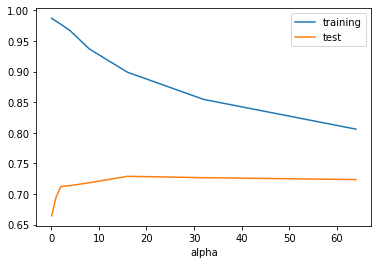

In [13]:
alphas2 = [0.1,1,2,4,8,16,32,64,128,256]
model2 = []
zero_features2 = []
test_f1_scores2 = []
train_f1_scores2 = []
eps = 0.001

for alpha in alphas2:
    model2.append(RidgeClassifier(alpha = alpha))
    model2[-1].fit(X_train,y_train)
    y_pred = model2[-1].predict(X_test)
    test_score = f1_score(y_test,y_pred)
    train_score = f1_score(y_train,model2[-1].predict(X_train))
    test_f1_scores2.append(test_score)
    train_f1_scores2.append(train_score)
    zeros = 0
    for c in model2[-1].coef_[0,:]:
        if (c < eps) and (c > -eps):
            zeros += 1
    zero_features2.append(zeros)
    print('Alpha: ', alpha, 'Train F1:',train_score,
          'Test F1:', test_score, 'Zeros:', zeros)

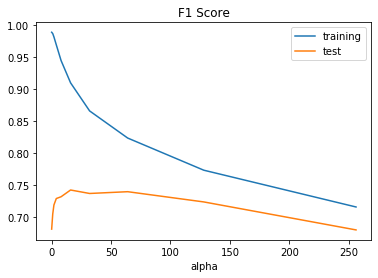

In [16]:
plt.plot(alphas2,train_f1_scores2,label='training')
plt.plot(alphas2,test_f1_scores2,label='test')
plt.xlabel('alpha')
plt.title('F1 Score')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import classification_report
print('Training set:\n')
print(classification_report(y_train,model2[5].predict(X_train)))
print('Test set:\n')
print(classification_report(y_test,model2[5].predict(X_test)))

Training set:

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      2872
           1       0.96      0.86      0.91      2155

    accuracy                           0.93      5027
   macro avg       0.93      0.92      0.92      5027
weighted avg       0.93      0.93      0.93      5027

Test set:

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1433
           1       0.82      0.67      0.74      1043

    accuracy                           0.80      2476
   macro avg       0.81      0.78      0.79      2476
weighted avg       0.80      0.80      0.80      2476



In [38]:
from sklearn.metrics import recall_score, precision_score
y_pred = model2[5].predict(X_test)
recall_score(y_test,y_pred)
precision_score(y_test,y_pred)

0.8151447661469933

In [19]:
coef = [(X_train.columns[i],model2[5].coef_[0,i]) for i in range(len(X_train.columns))]
coef = sorted(coef, key = lambda x: x[1], reverse=True)

print('Top 100 terms favoring Disaster:', ' '.join([x[0] for x in coef[:100]]))
print('Top 100 terms favoring Not Disaster:', ' '.join([x[0] for x in coef[-100:]]))

Top 100 terms favoring Disaster: hiroshima storm fires wildfire earthquake massacre tornado forest california terrorism KW_oil%20spill deaths suicide disaster typhoon report east near floods shooting derailment KW_typhoon dies evacuation mh KW_derailment KW_buildings%20burning spill flood train warning israeli drought crisis KW_suicide%20bombing accident japan city crash fire bombing attack found KW_bioterrorism myanmar KW_casualties plane KW_mass%20murder collapse police war crime york airport iran shot KW_sinkhole charged horrible bridge hurricane american calgary wild cars palestinian casualties murder derailed KW_hurricane may KW_evacuated home russia sunset after weather scene helicopter natural explosion nuclear KW_heat%20wave volcano cases flooding burning KW_drought minute north mass forecast houses dothraki disease severe distance incident unit terrorist
Top 100 terms favoring Not Disaster: KW_dead cat election jackson used book my jobs KW_electrocute easy KW_nuclear%20reactor

In [109]:
word_string = ''
for tweet in train.loc[train['target'] == 1, 'text'].apply(lambda x: re.sub('(#|[!-9]|http|@)[!-~]*(\s|$)', '',x)):
    word_string += tweet
    
wc = WordCloud().generate(word_string)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

NameError: name 'WordCloud' is not defined

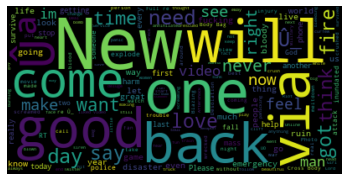

In [136]:
word_string = ''
for tweet in train.loc[train['target'] == 0, 'text'].apply(lambda x: re.sub('(#|[!-9]|http|@)[!-~]*(\s|$)', '',x)):
    word_string += tweet
    
wc = WordCloud().generate(word_string)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

In [128]:
train.loc[['åÊ' in tweet for tweet in train['text']],'text']

3       A [small] flood with bigåÊconsequences https:/...
205     General News Û¢åÊ'Demolition of houses on wat...
315     Pandemonium In Aba As Woman Delivers Baby With...
323     Sinjar Massacre Yazidis Blast Lack of Action O...
431     Photo: boyhaus: Heaven sent by JakeåÊ ÛÏAfter...
535     Reddit Will Now Quarantine OffensiveåÊContent ...
558     http://t.co/a0v1ybySOD Its the best time of da...
634     Horrible Accident |  Man Died In Wings of Airp...
1156    Russian Û÷food crematoriaÛª provoke outrage ...
1401    DireTube Information ÛÒ Egypt Cyprus and Gree...
1449    Texas Seeks Comment on Rules for Changes to Wi...
1594    Suicide Bomber Kills 13 At SaudiåÊMosque http:...
1819    Ogun smugglers engage Customs in shootoutåÊ: S...
1888    Police: Arsonist Deliberately Set Black Church...
1968    Photoset: hakogaku: ?åÊI am a kurd. i was born...
2034    Reddit Will Now Quarantine OffensiveåÊContent ...
2167    I peeped you frontin' I was in the jeepåÊsunk ...
2202    DISAST

In [151]:
disasters = train[train['target'] == 1]
disasters.reset_index()
for i in range(50):
    print(disasters.iloc[i]['text'],'\n')

So apparently there were bush fires near where I live over the weekend that I was totally oblivious to... 

Discovered Plane Debris Is From Missing Malaysia Airlines Flight 370 | TIME http://t.co/7fSn1GeWUX 

Strengthening partnerships #AfterHaiyan http://t.co/Ga14egplw9 #Haiyan #YolandaPh #Philippines #livelihood #disasterrecovery #disaster 

Good thing there was actually just a legit fire in the mall and nobody evacuated!! 

Strict liability in the context of an airplane accident: Pilot error is a common component of most aviation cr... http://t.co/6CZ3bOhRd4 

I liked a @YouTube video http://t.co/43sXG9Z6xh TREMOR IS NO JOKE!! [TREMOR DLC] [FATALITIES/X-RAY] 

Is LA at Risk for a Giant Wildfire? - Which Way L.A.? on KCRW http://t.co/6AgMkx2WW4 

Man wife get six years jail for setting ablaze niece
http://t.co/eV1ahOUCZA 

UD: Rescue (Structural Collapse) - Scott Road @ Ypres Road York (14 Trucks) 

New Giant Flames (GIANT FULL BLACK PANTOFEL) info/order sms:087809233445 pin:23928835